In [ ]:
"""
Author: Ayur Ninawe
Date: 2021-08-28
Last Modified by: Ayur Ninawe
Last Modified time: 2021-08-28
Title : Storing data on hive table by pre proccessing with spark and accessing with hive queries 
"""


In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession,SQLContext
from pyspark.sql import HiveContext 
from loggerfile import logger

In [ ]:
spark = SparkSession.builder.master("local").enableHiveSupport().appName('operations').getOrCreate()
sc=spark.sparkContext

In [ ]:
spark.sql("show databases").show()


In [ ]:
df = spark.read.csv("hdfs://localhost:9000/sparkData/CpuLogs/*.csv",header=True)
df2 = df.select("user_name","DateTime","keyboard","mouse")

In [11]:
df2.show()

+--------------------+-------------------+--------+------+
|           user_name|           DateTime|keyboard| mouse|
+--------------------+-------------------+--------+------+
|  iamnzm@outlook.com|2019-09-19 08:40:02|     1.0|  32.0|
|  iamnzm@outlook.com|2019-09-19 08:45:02|     0.0|   0.0|
|  iamnzm@outlook.com|2019-09-19 08:50:01|     0.0|   0.0|
|  iamnzm@outlook.com|2019-09-19 08:55:01|    11.0| 900.0|
|  iamnzm@outlook.com|2019-09-19 09:00:01|     2.0|  25.0|
|  iamnzm@outlook.com|2019-09-19 09:05:01|    37.0| 336.0|
|deepshukla292@gma...|2019-09-19 09:05:01|     0.0|  55.0|
|  iamnzm@outlook.com|2019-09-19 09:10:01|     0.0| 136.0|
|deepshukla292@gma...|2019-09-19 09:10:01|     6.0|1112.0|
|  iamnzm@outlook.com|2019-09-19 09:15:02|     0.0|  84.0|
|deepshukla292@gma...|2019-09-19 09:15:02|     0.0| 357.0|
|markfernandes66@g...|2019-09-19 09:15:01|    20.0| 670.0|
|markfernandes66@g...|2019-09-19 09:10:01|    17.0|   0.0|
|markfernandes66@g...|2019-09-19 09:20:01|    29.0|1895.

In [12]:
df2.createOrReplaceTempView("LogData")

## Loading data from dataframe to hive table

In [13]:
spark.sql("create table default.new_data as select * from LogData")
#df2.write.format("orc").mode("overwrite").saveAsTable("default.new_data")

2021-08-30 00:19:47,051 WARN analysis.ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
2021-08-30 00:19:48,119 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
2021-08-30 00:19:48,582 WARN conf.HiveConf: HiveConf of name hive.metastore.wm.default.pool.size does not exist
2021-08-30 00:19:48,582 WARN conf.HiveConf: HiveConf of name hive.llap.task.scheduler.preempt.independent does not exist
2021-08-30 00:19:48,582 WARN conf.HiveConf: HiveConf of name hive.llap.output.format.arrow does not exist
2021-08-30 00:19:48,582 WARN conf.HiveConf: HiveConf of name hive.tez.llap.min.reducer.per.executor does not exist
2021-08-30 00:19:48,582 WARN conf.HiveConf: HiveConf of name hive.arrow.root.allocator.limit does not exist
202

DataFrame[]

In [5]:
from pyhive import hive
import pandas as pd

In [6]:
conn = hive.Connection(host='localhost',port=10000,database='default')

In [7]:
user_count=pd.read_sql("select user_name, count('') as total_count from new_data group by user_name",conn)
print(user_count)

                      user_name  total_count
0  bhagyashrichalke21@gmail.com          482
1         damodharn21@gmail.com          253
2       deepshukla292@gmail.com          565
3            iamnzm@outlook.com          614
4     markfernandes66@gmail.com          508
5         rahilstar11@gmail.com          551
6      salinabodale73@gmail.com          569
7         sharlawar77@gmail.com          580


In [8]:
df5 = pd.read_sql("select user_name ,count('') as total from new_data where keyboard !=0.0 or mouse!=0.0 group by user_name",conn)
print(df5)

                      user_name  total
0  bhagyashrichalke21@gmail.com    361
1         damodharn21@gmail.com    191
2       deepshukla292@gmail.com    475
3            iamnzm@outlook.com    459
4     markfernandes66@gmail.com    389
5         rahilstar11@gmail.com    399
6      salinabodale73@gmail.com    440
7         sharlawar77@gmail.com    457


## LOWEST AVG HOURS

In [9]:
lowest_work_time=pd.read_sql("select user_name ,((((count('')-1)*5)*60)/6) as working_sec from new_data where keyboard!=0.0 or mouse!=0.0 group by user_name",conn)
lowest_work_time = lowest_work_time.sort_values('working_sec')
print(lowest_work_time)

                      user_name  working_sec
1         damodharn21@gmail.com       9500.0
0  bhagyashrichalke21@gmail.com      18000.0
4     markfernandes66@gmail.com      19400.0
5         rahilstar11@gmail.com      19900.0
6      salinabodale73@gmail.com      21950.0
7         sharlawar77@gmail.com      22800.0
3            iamnzm@outlook.com      22900.0
2       deepshukla292@gmail.com      23700.0


In [10]:
lowest_average_work_hour = lowest_work_time[["user_name","working_sec"]]
lowest_average_work_hour["working_sec"]= pd.to_datetime(lowest_average_work_hour['working_sec'] ,unit='s').dt.strftime("%H:%M")
lowest_average_work_hour = lowest_average_work_hour.sort_values('working_sec')
lowest_average_work_hour.rename(columns={'working_sec': 'working_hour'}, inplace=True)
print(lowest_average_work_hour)

                      user_name working_hour
1         damodharn21@gmail.com        02:38
0  bhagyashrichalke21@gmail.com        05:00
4     markfernandes66@gmail.com        05:23
5         rahilstar11@gmail.com        05:31
6      salinabodale73@gmail.com        06:05
7         sharlawar77@gmail.com        06:20
3            iamnzm@outlook.com        06:21
2       deepshukla292@gmail.com        06:35


## HIGHEST AVG HOURS

In [11]:
highest_work_time=pd.read_sql("select user_name ,((((count('')-1)*5)*60)/6) as working_sec from new_data where keyboard!=0.0 or mouse!=0.0 group by user_name",conn)
highest_work_time= highest_work_time.sort_values(by='working_sec',ascending=False)
print(highest_work_time)


                      user_name  working_sec
2       deepshukla292@gmail.com      23700.0
3            iamnzm@outlook.com      22900.0
7         sharlawar77@gmail.com      22800.0
6      salinabodale73@gmail.com      21950.0
5         rahilstar11@gmail.com      19900.0
4     markfernandes66@gmail.com      19400.0
0  bhagyashrichalke21@gmail.com      18000.0
1         damodharn21@gmail.com       9500.0


In [12]:
highest_average_work_hour = highest_work_time[["user_name","working_sec"]]
highest_average_work_hour["working_sec"]= pd.to_datetime(highest_average_work_hour['working_sec'] ,unit='s').dt.strftime("%H:%M")
highest_average_work_hour = highest_average_work_hour.sort_values('working_sec',ascending=False)
highest_average_work_hour.rename(columns={'working_sec': 'working_hour'}, inplace=True)
print(highest_average_work_hour)

                      user_name working_hour
2       deepshukla292@gmail.com        06:35
3            iamnzm@outlook.com        06:21
7         sharlawar77@gmail.com        06:20
6      salinabodale73@gmail.com        06:05
5         rahilstar11@gmail.com        05:31
4     markfernandes66@gmail.com        05:23
0  bhagyashrichalke21@gmail.com        05:00
1         damodharn21@gmail.com        02:38


## IDLE COUNT

In [13]:
idle_count = pd.read_sql("select user_name ,count('') as total from new_data where keyboard=0 and mouse=0 group by user_name",conn)
print(idle_count)

                      user_name  total
0  bhagyashrichalke21@gmail.com    121
1         damodharn21@gmail.com     62
2       deepshukla292@gmail.com     90
3            iamnzm@outlook.com    155
4     markfernandes66@gmail.com    119
5         rahilstar11@gmail.com    152
6      salinabodale73@gmail.com    129
7         sharlawar77@gmail.com    123


In [14]:
highest_idle_time = pd.read_sql("select user_name ,((((count('')-1)*5)*60)/6) as idle_sec from new_data where keyboard=0.0 and mouse=0.0 group by user_name",conn)
highest_idle_time=highest_idle_time.sort_values(by='idle_sec',ascending=False)
print(highest_idle_time)

                      user_name  idle_sec
3            iamnzm@outlook.com    7700.0
5         rahilstar11@gmail.com    7550.0
6      salinabodale73@gmail.com    6400.0
7         sharlawar77@gmail.com    6100.0
0  bhagyashrichalke21@gmail.com    6000.0
4     markfernandes66@gmail.com    5900.0
2       deepshukla292@gmail.com    4450.0
1         damodharn21@gmail.com    3050.0


In [15]:
idle_hour = highest_idle_time[["user_name","idle_sec"]]
idle_hour["idle_sec"]= pd.to_datetime(idle_hour['idle_sec'] ,unit='s').dt.strftime("%H:%M")
idle_hour = idle_hour.sort_values('idle_sec',ascending=False)
idle_hour.rename(columns={'idle_sec': 'idle_hour'}, inplace=True)
print(idle_hour)

                      user_name idle_hour
3            iamnzm@outlook.com     02:08
5         rahilstar11@gmail.com     02:05
6      salinabodale73@gmail.com     01:46
7         sharlawar77@gmail.com     01:41
0  bhagyashrichalke21@gmail.com     01:40
4     markfernandes66@gmail.com     01:38
2       deepshukla292@gmail.com     01:14
1         damodharn21@gmail.com     00:50


# VISUALIZATION

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


In [17]:
username= highest_work_time['user_name']
work=highest_work_time['working_sec']

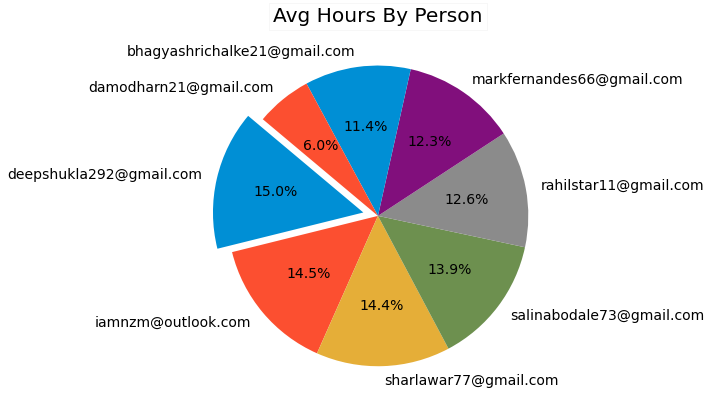

In [18]:
try:
    plt.style.use("fivethirtyeight")
    fig = plt.figure(figsize=(6,12))
    fig.patch.set_facecolor('w')
    explode = (0.1, 0, 0, 0, 0, 0, 0, 0)
    plt.pie(work,labels=username,autopct='%1.1f%%',startangle=140,explode= explode)
    plt.title('Avg Hours By Person',bbox={'facecolor':'1', 'pad':4})

except Exception as e:
    logger.info(e)


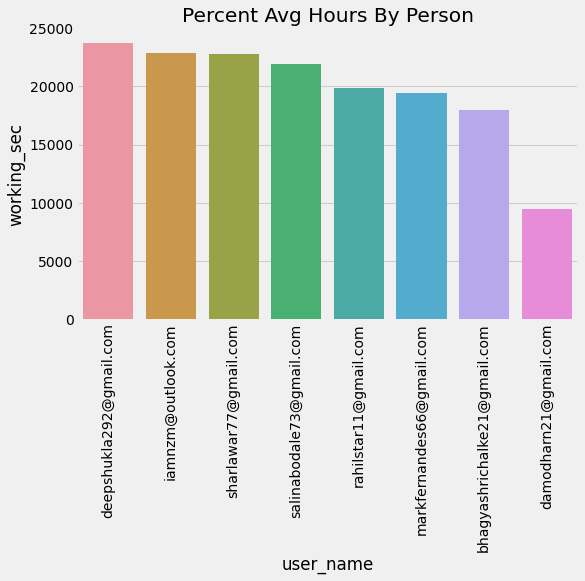

In [19]:
try:
    df = highest_work_time
    plt.figure(figsize = (8,5))
    sns.barplot(x = 'user_name',y='working_sec',data = df)
    plt.title("Percent Avg Hours By Person")
    plt.ylim(0,25000)
    plt.xticks(rotation='vertical')
    plt.show()
except Exception as e:
    logger.info(e)

In [20]:
user_count=pd.read_sql("select user_name, count('') as total_count from new_data group by user_name",conn)
print(user_count)

                      user_name  total_count
0  bhagyashrichalke21@gmail.com          482
1         damodharn21@gmail.com          253
2       deepshukla292@gmail.com          565
3            iamnzm@outlook.com          614
4     markfernandes66@gmail.com          508
5         rahilstar11@gmail.com          551
6      salinabodale73@gmail.com          569
7         sharlawar77@gmail.com          580


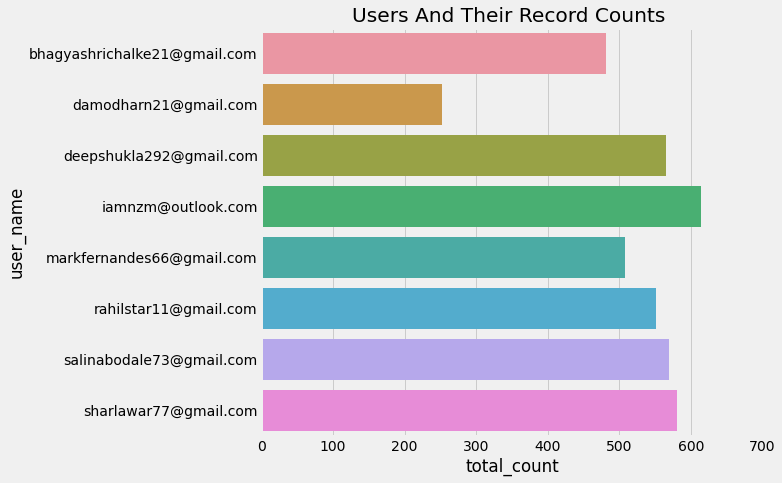

In [21]:
try:
    df = user_count
    plt.figure(figsize = (8,7))
    sns.barplot(x = 'total_count',y='user_name',data = df)
    plt.title('Users And Their Record Counts ')
    plt.xlim(0,700)
    plt.show()
except Exception as e:
    logger.info(e)

total count visualization

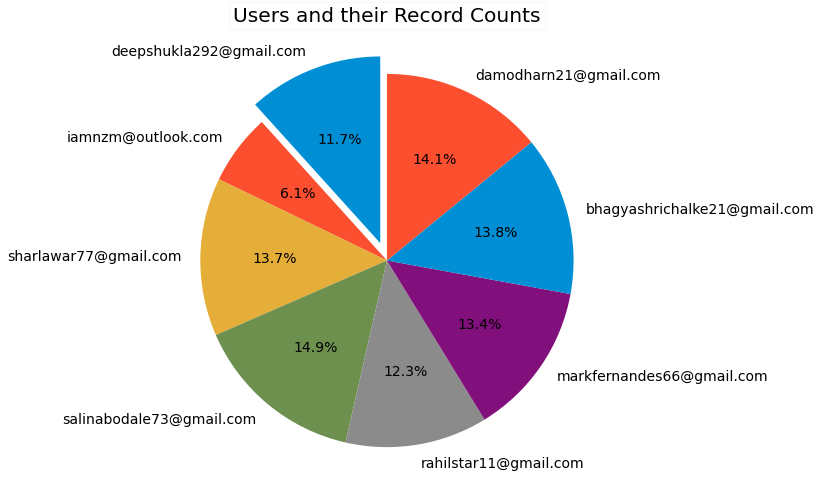

In [22]:
try:
    
    user_data = user_count["user_name"]
    count_data = user_count["total_count"]

    fig = plt.figure(figsize=(10,8))
    fig.patch.set_facecolor('w')
    explode = (0.1, 0, 0, 0, 0, 0, 0, 0)
    # Plot
    plt.pie(count_data,labels = username,autopct='%1.1f%%',startangle=90,explode=explode,)
    plt.title('Users and their Record Counts',bbox={'facecolor':'1', 'pad':4})
except Exception as e:
    logger.info(e)

Idle hour visualization

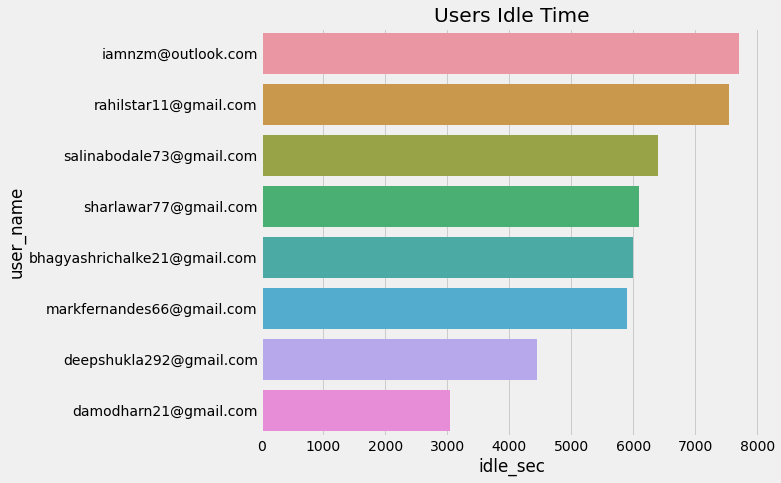

In [23]:
try:
    df = highest_idle_time
    plt.figure(figsize = (8,7))
    sns.barplot(x = 'idle_sec',y='user_name',data = df)
    plt.title('Users Idle Time')
    plt.show()
except Exception as e:
    logger.info(e)